### Import Modules

<br>

In [1]:
import requests
import json
import time
import itertools
import wget
import os
import pickle
import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import precision_recall_curve
import scipy

sns.set_style('white')
import tensorflow as tf
import pandas as pd
import keras
from keras.applications.vgg16 import VGG16
from keras.callbacks import LearningRateScheduler
from keras import callbacks
from keras import regularizers as reg
from keras.optimizers import SGD, Adam
from keras.models import Sequential , Model
from keras.layers import Dense, Dropout, Flatten, Input, concatenate
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.initializers as init
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.




<br>
### Open the Preprocessed Poster Data

<br>
Image data is stored in a numpy format and existing on a pickle dump file and numerical features in a csv file

<br>
** 1 - Image Features:**

<br>

In [2]:
x_train_dict = pickle.load(open('training_num.pik' , 'rb'))


<br>
** 2 - Color Numerical Features: **

<br>

In [3]:
# Open File
x_train_raw = pd.read_csv('Features_All.csv')

# Select features
# x_data = x_train_raw.loc[: , ['mR' , 'mG' , 'mB' , 'vardR' , 'vardG' , 'vardB' , 'De1' , 'De2' , 'De3']].values
x_data = x_train_raw.loc[: , ['mR' , 'mG' , 'mB' , 'stdR' , 'stdG' , 'stdB' , 'Dc1' , 'Dc2' , 'Dc3']].values



<br>
### Specify the training/test split

<br>
 - The data will be split into training and test for validation purpose
 - Data augmentation will be subsequently applied for both training and test
 
 <br>

In [4]:
# Specify the split index
# ------------------------
train_split = 8000


# Define training/test data for image data:
# -----------------------------------------
# Extract the input arrays from the data container
xi_train_raw = x_train_dict['images']

# Apply the test / train split
xi_train = np.array(xi_train_raw)[:train_split,: ,: , :]
xi_test  = np.array(xi_train_raw)[train_split:,: ,: , :]


# Define training/test data for numerical data:
# ---------------------------------------------
# Apply the test / train split
xn_train = x_data[:train_split,:]
xn_test  = x_data[train_split:,:]

print 'Image Data Shape : ' , xi_train.shape
print 'Numerical Data Shape : ' , xn_train.shape


Image Data Shape :  (8000, 128, 85, 3)
Numerical Data Shape :  (8000, 9)




<br>
### Prepare Data for input

<br>
 - Determine the data axis order according tothe keras configuration
 - Define the input and its attributes
 - Center input data and ensure its type as float 
 - Pre-process labels
 
 <br>
 
** 1 - Arrange Data for Input:**

<br>

** a - Image Data **

<br>

In [5]:
# Define the image number of rows
img_rows = xi_train.shape[1]

# Dfine the image number of columns
img_cols = xi_train.shape[2]

# Re-arrange if channels first configuration
if K.image_data_format() == 'channels_first':
    xi_train = xi_train.reshape(xi_train.shape[0], 3, img_rows, img_cols)
    
    # Define Input Shape
    input_shape = (3, img_rows, img_cols)

# Re-arrange if channels last configuration
else:
    xi_train = xi_train.reshape(xi_train.shape[0], img_rows, img_cols, 3)
    
    # Define Input shape
    input_shape = (img_rows, img_cols, 3)

# Define Model Input
image_input = Input(shape = input_shape , name = 'imag_in')



<br>
** b - Numerical Data:**

<br>

In [6]:
# Dfine the data number of columns
dat_cols = xn_train.shape[1]

# Define Model Input
num_input = Input(shape = (dat_cols,), name = 'num_in')


<br>
** 2 - Pre-process Data: **

<br>

In [7]:
# Image Data:
# ----------

# Transform to float
xi_train = xi_train.astype('float32')
xi_test  = xi_test.astype('float32')

# Center the data
xi_train /= 255.0
xi_test  /= 255.0

# Numerical Data:
# ---------------

# Transform to float
xn_train = xn_train.astype('float32')
xn_test  = xn_test.astype('float32')

# Center the data
xn_train -= xn_train.mean(0)
xn_test  -= xn_test.mean(0)

# Scale the data
xn_train /= xn_train.std(0)
xn_test  /= xn_test.std(0)



# Display image train Data attributes
print 'Image train shape:', xi_train.shape
print  xi_train.shape[0], 'train samples'

# Display numeric train data attributes
print 'Numeric Train shape:', xn_train.shape
print  xn_train.shape[0], 'train samples'

Image train shape: (8000, 128, 85, 3)
8000 train samples
Numeric Train shape: (8000, 9)
8000 train samples



<br>
** 3 - Output Data Pre-processing : **

<br>

In [8]:
# Extract Labels from File
y_raw = pd.read_csv('Genres_labels_All_cleaned.csv')

# Split into train and test
y_train = y_raw.iloc[:, 1:-1].values[:train_split, :]
y_test  = y_raw.iloc[:, 1:-1].values[train_split:, :]

# Define the number of classes
num_classes = y_train.shape[1]

print 'number of classes:  ' , num_classes

number of classes:   14



<br>
### Model Construction

<br>
 - Specify regularization paramter
 - construct the MLP model for the numeric feaures
 - construct the CNN model based on the latest variation for the images
 - Merge both models
 
<br>
** 1 - Initiate regularization: **

<br>

In [46]:
# Specify regularization parameter
reg_par = 0.01


<br>
** 2 - MLP Model:**

<br>

In [47]:
# ---------- Input  ----------------
x = num_input

# ------------ Fully Connected ----------
x = Dense(32 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

#  ----------- Dropout ---------
x = Dropout(0.5)(x)

# ------------- Fully Connected --------
x = Dense(64, activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

# ------------ Dropout --------------
x = Dropout(0.5)(x)

# ------------- Fully Connected --------
num_out = Dense(32 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)



<br>
** 3 - Auto Encoder Model:**

<br>

In [48]:
# ---------- Input  ----------------
x = image_input

# -----------------------------------------------------------------------------------

# --- input layer ---
x = Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=input_shape , 
                 kernel_initializer = init.he_normal(109),
                 kernel_regularizer = reg.l2(reg_par))(x)

# ------Dropout -------
x = Dropout(0.3)(x)

# -----Batch Normalization -----
x = BatchNormalization()(x)

# --- max pool ---
x = MaxPooling2D(pool_size=(2, 2))(x)


# -----------------------------------------------------------------------------------------------

# ---- Conv Layer ---
x = Conv2D(32, kernel_size=(5, 5), activation='relu', 
                 kernel_initializer = init.he_normal(109),
                 kernel_regularizer = reg.l2(reg_par))(x)

# ------Dropout -------
x = Dropout(0.3)(x)

# -----Batch Normalization -----
x = BatchNormalization()(x)

# --- max pool ---
x = MaxPooling2D(pool_size=(2, 2))(x)


# -----------------------------------------------------------------------------------------------

# --- Conv layer ---
x = Conv2D(64, kernel_size=(3, 3), activation='relu',
                 kernel_initializer = init.he_normal(109),
                 kernel_regularizer = reg.l2(reg_par))(x)

# ------Dropout -------
x = Dropout(0.3)(x)

# -----Batch Normalization -----
x = BatchNormalization()(x)

# --- max pool ---
x = MaxPooling2D(pool_size=(2, 2))(x)

# -----------------------------------------------------------------------------------------------

# --- Conv layer ---
x = Conv2D(64, kernel_size=(3, 3), activation='relu' ,
                 kernel_initializer = init.he_normal(109),
                 kernel_regularizer = reg.l2(reg_par))(x)

# ------Dropout -------
x = Dropout(0.3)(x)

# -----Batch Normalization -----
x = BatchNormalization()(x)

# --- max pool ---
x = MaxPooling2D(pool_size=(2, 2))(x)

#------------------------------------------------------------------------------------------------

# flatten for fully connected classification layer
x = Flatten()(x)

# --- fully connected layer ---
x = Dense(128, activation='relu',
                kernel_initializer = init.he_normal(109),
                kernel_regularizer = reg.l2(reg_par))(x)

# ------Dropout -------
x = Dropout(0.5)(x)

# -----Batch Normalization -----
x = BatchNormalization()(x)

# ------------------------------------------------------------------------------------------------

# --- fully connected layer ---
x = Dense(64, activation='relu' ,
                kernel_initializer = init.he_normal(109),
                kernel_regularizer = reg.l2(reg_par))(x)

# ------Dropout -------
x = Dropout(0.5)(x)

# -----Batch Normalization -----
x = BatchNormalization()(x)


# ------------------------------------------------------------------------------------


im_out = Dense(128 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)




<br>
** 4 - Model Merge and packaging: **


<br>

In [49]:
# ---------------- Concatenate Inputs ---------
x = keras.layers.concatenate([im_out , num_out])

# ------------ Fully Connected ----------
x = Dense(128 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

#  ----------- Dropout ---------
x = Dropout(0.5)(x)

# -------------------------------------------------------------------------------------

# ------------ Fully Connected ----------
x = Dense(64 , activation = 'relu' , kernel_initializer = init.he_normal(109),
          kernel_regularizer = reg.l2(reg_par))(x)

#  ----------- Dropout ---------
x = Dropout(0.5)(x)

# ------------------------------------------------------------------------------------

# ------------ Output ---------------

mod_out = Dense(num_classes , activation = 'sigmoid' , name = 'comb_out')(x)

# --------- Model Packing ----------
model = Model(inputs = [image_input , num_input] , outputs = mod_out)
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
imag_in (InputLayer)             (None, 128, 85, 3)    0                                            
____________________________________________________________________________________________________
flatten_5 (Flatten)              (None, 32640)         0                                            
____________________________________________________________________________________________________
dense_63 (Dense)                 (None, 2048)          66848768                                     
____________________________________________________________________________________________________
dropout_49 (Dropout)             (None, 2048)          0                                            
___________________________________________________________________________________________


<br>
### Model Compilation and Intiation




<br>
** 1 - Model Compilation : **

<br>

In [50]:
# Specifying Optimization Method
sgd = SGD(lr=0 , momentum = 0.99)

# Model Comilation
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])


<br>
** 3 - Training Parameters: **

<br>

In [51]:
# Batch Size
batch_size = 32

# epochs
epochs = 50


<br>
** 4 - Callback Functions: **

<br>

In [52]:
def step_decay(epoch):
    lrate = 0.001
    if epoch > 20 and epoch <= 30:
        lrate = 0.0001
    elif epoch > 30:
        lrate = 1e-6
    else:
        lrate = lrate
        
    return lrate

lr = LearningRateScheduler(step_decay)
callbacks_list = [lr]


<br>
### Training Execution

<br>

In [ ]:

history = model.fit({'imag_in': xi_train , 'num_in' : xn_train} , {'comb_out' : y_train},            
                              epochs=epochs,
                              validation_data = ({'imag_in' : xi_test , 'num_in' : xn_test} , {'comb_out' : y_test}),
                              batch_size = batch_size,
                              callbacks = callbacks_list)

Train on 8000 samples, validate on 1988 samples
Epoch 1/50
8000/8000 [==============================] - 23s - loss: 51.5298 - acc: 0.7697 - val_loss: 33.1714 - val_acc: 0.8440

<br>
** Plot Accurracy**

<br>

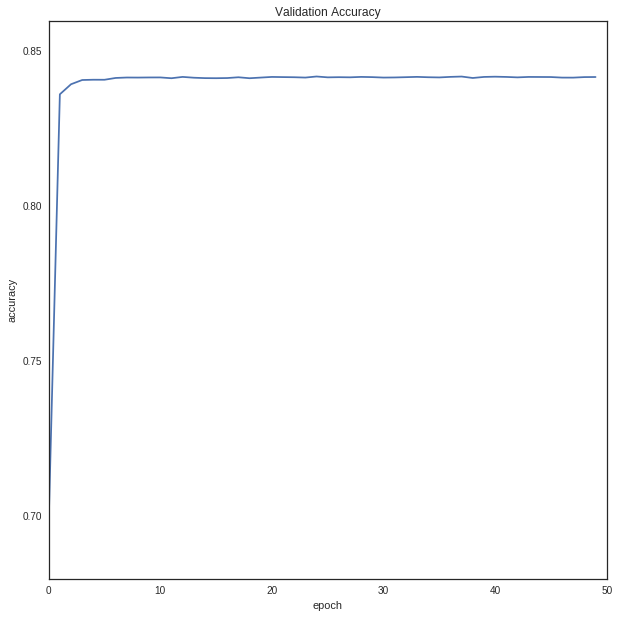

In [45]:
fig = plt.figure (figsize = (10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(history.history['acc'])
ax1.set_xlabel("epoch")
ax1.set_title('Validation Accuracy')
ax1.set_ylabel("accuracy")
plt.show()


<br>
### Export Results to File:

<br>
** 1 - Export Weights : **

<br>

In [ ]:
import h5py as h5py

model.save('vgg16.h5')


<br>
** 2 - Export Accurracy **

<br>

In [ ]:
# Conctruct Accurrracy Data Frame
Acc_vgg16 = pd.DataFrame(history.history['acc'] , columns = ['Accuracy'])

# Write to File
Acc_vgg16.to_csv('vgg16_acc.csv')